In [1]:
import os
import pickle
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.colors as mcolors
import pandas as pd

from code_.model_activations.configs import model_cfg as cfg
from code_.eigen_analysis.tools import *
from code_.model_activations.loading import load_full_identifier

from config import CACHE, DATA, PCA_PATH, FIGURES, RESULTS
y_lim = {'naturalscenes':0.45, 'majajhong': 0.65, 'things':0.15}


## Num PCs Required to Explain X% Variance

In [3]:
dataset = 'naturalscenes'
region = 'midventral visual stream'
ex_var=0.85
incremental = True
components=7000


dataset = 'majajhong'
region = 'IT'
ex_var=0.85
incremental = False
components=2000

In [9]:
PCA_PATH = os.path.join(CACHE, 'pca')

data_dict = {'expansion':{'features':[],'num_components':[],'score':[], 'lower':[], 'upper':[]},
           'fully_connected':{'features':[],'num_components':[],'score':[],'lower':[], 'upper':[]},
           'vit':{'features':[],'num_components':[],'score':[], 'lower':[], 'upper':[]},
          }
models = ['expansion','vit', 'fully_connected']

for i, model_name in enumerate(models):
    
    for j, f in enumerate(cfg[dataset]['models'][model_name]['features']):
        # print(model_name, f)
        data_dict[model_name]['features'].append(str(f))
                    
        iden = load_full_identifier(model_name=model_name, 
                 features=f, 
                 layers=5,
                 principal_components=components,
                 dataset=dataset)
    
        file_path = f'{PCA_PATH}/{iden}'
        
        if incremental:
            file_path += '_incremental'
        with open(file_path, 'rb') as file:
            pca = pickle.load(file)
            # print(pca)
        num_components_required = num_pcs_required(pca.explained_variance_ratio_,explained_variance=ex_var)
        data_dict[model_name]['num_components'].append(num_components_required)
        del pca
        
        file_name = os.path.join(RESULTS, f'bootstrap-results-{model_name}-{dataset}-{region}.csv')
        scores = pd.read_csv(file_name)
        scores['score'] = scores['score'].apply(lambda x: float(x.replace("tensor(", "").replace(")", "")))
        data_dict[model_name]['score'].append(float(scores[scores.features == f]['score'].values))
        data_dict[model_name]['lower'].append(float(scores[scores.features == f]['lower'].values))
        data_dict[model_name]['upper'].append(float(scores[scores.features == f]['upper'].values))
        del scores

/tmp/ipykernel_614751/4183907321.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data_dict[model_name]['score'].append(float(scores[scores.features == f]['score'].values))
/tmp/ipykernel_614751/4183907321.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data_dict[model_name]['lower'].append(float(scores[scores.features == f]['lower'].values))
/tmp/ipykernel_614751/4183907321.py:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data_dict[model_name]['upper'

/tmp/ipykernel_614751/1336744558.py:33: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
/tmp/ipykernel_614751/1336744558.py:33: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
/tmp/ipykernel_614751/1336744558.py:33: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


0    0.014894
1    0.014675
2    0.013993
3    0.012248
4    0.012083
dtype: float64
0    0.017569
1    0.015712
2    0.013368
3    0.013142
4    0.012769
dtype: float64
0    0.016949
1    0.015455
2    0.015322
3    0.015685
dtype: float64
0    0.016706
1    0.015766
2    0.016873
3    0.016731
dtype: float64
0    0.016229
1    0.015762
2    0.016306
3    0.015589
4    0.016174
dtype: float64
0    0.016586
1    0.016967
2    0.016635
3    0.016226
4    0.016290
dtype: float64


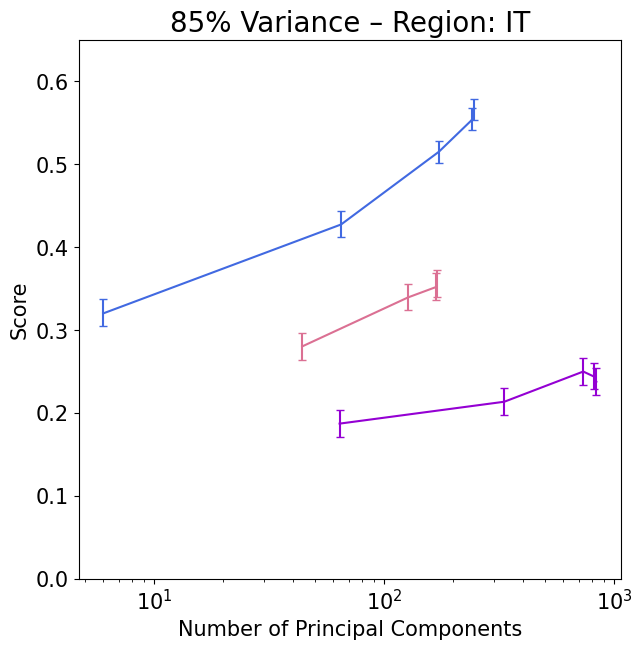

In [10]:
rcParams['figure.figsize'] = (7, 7)
line_colors = {
    'expansion':       'royalblue',
    'vit':             'palevioletred',
    'fully_connected': 'darkviolet'
}

# ——— Convert each entry in data_dict into a DataFrame —————————————————————————
for key, data in list(data_dict.items()):
    if isinstance(data, pd.DataFrame):
        df = data.copy()
    else:
        # assume list of dicts or dict of lists
        df = pd.DataFrame(data)
    data_dict[key] = df

# ——— Flatten any list/array entries to scalars ———————————————————————————————
for key, df in data_dict.items():
    for col in ['score', 'lower', 'upper']:
        # If the column contains lists/arrays, take their mean; else cast to float
        df[col] = df[col].apply(
            lambda v: float(np.mean(v)) if isinstance(v, (list, np.ndarray)) else float(v)
        )
    data_dict[key] = df  # overwrite with cleaned DataFrame

# ——— Create figure & axis —————————————————————————————————————————————————
fig, ax = plt.subplots()

def plot_series(key, label):
    """Plot one line with its error bars."""
    df = data_dict[key]
    # Plot main line
    sns.lineplot(
        x='num_components',
        y='score',
        data=df,
        color=line_colors[key],
        label=label,
        ax=ax,
        ci=None
    )
    # Compute error magnitudes
    lower_err = df['score'] - df['lower']
    upper_err = df['upper'] - df['score']
    print(lower_err)
    print(upper_err)
    # Add vertical error bars
    ax.errorbar(
        df['num_components'],
        df['score'],
        yerr=[lower_err.values, upper_err.values],
        fmt='none',
        ecolor=line_colors[key],
        capsize=3
    )

# ——— Plot each condition ————————————————————————————————————————————————
plot_series('expansion',       'Expansion')
plot_series('vit',             'ViT')
plot_series('fully_connected', 'Fully Connected')

# ——— Final formatting ——————————————————————————————————————————————————
ax.set_xscale('log')
ax.set_xlabel('Number of Principal Components', size=15)
ax.set_ylabel('Score', size=15)
ax.tick_params(labelsize=15)
ax.set_title(f'{int(ex_var*100)}% Variance – Region: {region}', size=20)

# Legend only if region == 'V4'
if region == 'V4':
    ax.legend()
else:
    ax.get_legend().remove()
plt.ylim(0,y_lim[dataset])

# ——— Save & display ———————————————————————————————————————————————————
output_path = os.path.join(
    FIGURES,
    f'figure_S5_{dataset}_{region}_var={ex_var:.2f}.png'
)
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()